<a href="https://colab.research.google.com/github/sberniz/DS-Unit-2-Applied-Modeling/blob/master/module1-define-ml-problems/LS_DS_231_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict? 'base mSRP
- [ ] Is your problem regression or classification? 'Regression'
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target. 'it looks like normal distributionn'
- [ ] Choose your evaluation metric(s).'r2score and mean absolute error'
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model. Make,model,model year,range, and clean air elegibility
    - Are some observations outliers? Will you exclude them? yes 0 and 845,000, will exclude them
    - Will you do a random split or a time-based split?         randomtestsplit
- [+ ] Begin to clean and explore your data.
- [ +] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [132]:
%%capture
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/sberniz/build2/master/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [133]:
%%capture
import sys

if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/sberniz/build2/master/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from scipy import stats
from category_encoders import OneHotEncoder, OrdinalEncoder
import plotly.express as px


In [135]:
electric_cars = pd.read_csv(DATA_PATH+'Electric_Vehicle_Population_Data.csv')
electric_cars.shape

(58383, 15)

In [136]:
electric_cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58383 entries, 0 to 58382
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   VIN (1-10)                                         58383 non-null  object 
 1   County                                             58382 non-null  object 
 2   City                                               58383 non-null  object 
 3   State                                              58383 non-null  object 
 4   ZIP Code                                           58383 non-null  int64  
 5   Model Year                                         58383 non-null  int64  
 6   Make                                               58383 non-null  object 
 7   Model                                              58383 non-null  object 
 8   Electric Vehicle Type                              58383 non-null  object 
 9   Clean 

In [137]:
electric_cars.head()

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
0,5YJ3E1EA9L,King,Auburn,WA,98001,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266,0,47.0,4759478,POINT (-122.266685 47.308313)
1,1FADP3R47E,King,Seattle,WA,98103,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,76,29170,36.0,205611143,POINT (-122.343577 47.672491)
2,5YJSA1H1XE,King,Seattle,WA,98109,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,36.0,7424532,POINT (-122.346385 47.630685)
3,1N4BZ0CP9G,King,Seattle,WA,98103,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,36.0,252339384,POINT (-122.343577 47.672491)
4,WBY1Z2C56E,King,Bellevue,WA,98006,2014,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,41350,41.0,213103376,POINT (-122.151342 47.560192)


In [138]:
electric_cars['Electric Vehicle Type'].value_counts()

Battery Electric Vehicle (BEV)            40596
Plug-in Hybrid Electric Vehicle (PHEV)    17787
Name: Electric Vehicle Type, dtype: int64

In [139]:
electric_cars['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts()

Clean Alternative Fuel Vehicle Eligible    47945
Not eligible due to low battery range      10438
Name: Clean Alternative Fuel Vehicle (CAFV) Eligibility, dtype: int64

In [140]:
electric_cars['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts(normalize=True) #Basemodel if going with clasification weather is eligible or not

Clean Alternative Fuel Vehicle Eligible    0.821215
Not eligible due to low battery range      0.178785
Name: Clean Alternative Fuel Vehicle (CAFV) Eligibility, dtype: float64

In [141]:
electric_cars['Base MSRP'].mean() #Baseline if going to predict base msrp

37678.85351900382

In [142]:
electric_cars

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
0,5YJ3E1EA9L,King,Auburn,WA,98001,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,266,0,47.0,4759478,POINT (-122.266685 47.308313)
1,1FADP3R47E,King,Seattle,WA,98103,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,76,29170,36.0,205611143,POINT (-122.343577 47.672491)
2,5YJSA1H1XE,King,Seattle,WA,98109,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,36.0,7424532,POINT (-122.346385 47.630685)
3,1N4BZ0CP9G,King,Seattle,WA,98103,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,36.0,252339384,POINT (-122.343577 47.672491)
4,WBY1Z2C56E,King,Bellevue,WA,98006,2014,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,41350,41.0,213103376,POINT (-122.151342 47.560192)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58378,JN1AZ0CP4B,Pierce,Tacoma,WA,98409,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,32780,29.0,214353912,POINT (-122.480106 47.211446)
58379,1N4AZ1CP0J,King,Seattle,WA,98119,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151,29990,36.0,129767522,POINT (-122.36772100000002 47.639264)
58380,1N4AZ0CPXF,King,Seattle,WA,98115,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010,46.0,142752711,POINT (-122.297534 47.685291)
58381,5YJSA1CG2D,King,Seattle,WA,98106,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900,34.0,237945956,POINT (-122.35495400000002 47.537664)


In [143]:
electric_cars['Base MSRP'].describe()

count     58383.000000
mean      37678.853519
std       19681.979238
min           0.000000
25%       29990.000000
50%       35000.000000
75%       39145.000000
max      845000.000000
Name: Base MSRP, dtype: float64

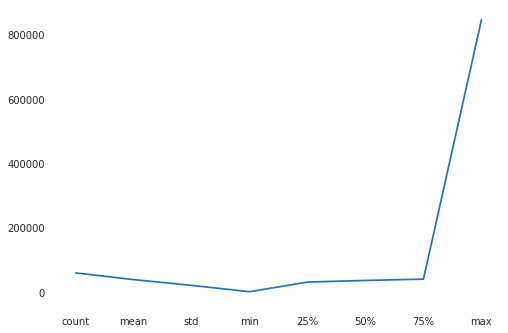

In [144]:
electric_cars['Base MSRP'].describe().plot();

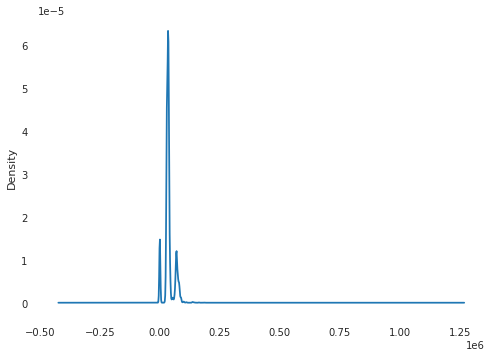

In [145]:
electric_cars['Base MSRP'].plot(kind='density')

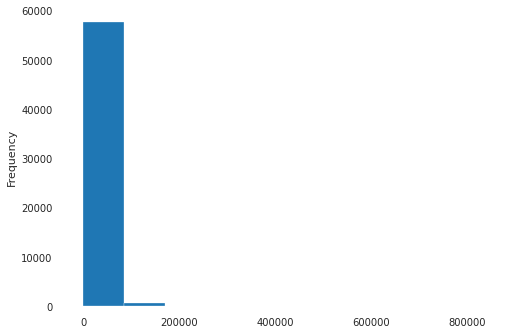

In [146]:
electric_cars['Base MSRP'].plot(kind='hist')

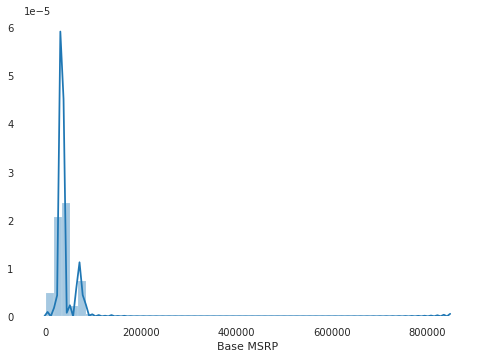

In [147]:
sns.distplot(electric_cars['Base MSRP'])

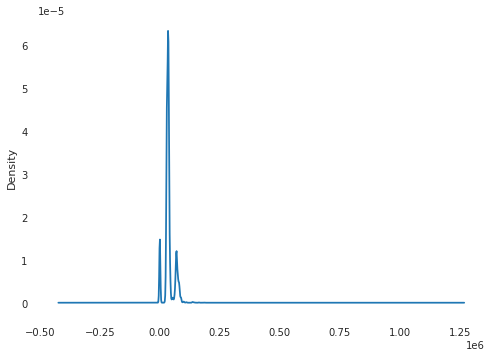

In [148]:
electric_cars['Base MSRP'].plot.density() #mostly normal distribution with some outliers

In [149]:
electric_cars['Base MSRP'].value_counts()

36000     6260
0         4805
35000     3915
29010     3243
29990     2759
          ... 
91250        3
30315        3
94400        2
45490        1
845000       1
Name: Base MSRP, Length: 151, dtype: int64

In [150]:
electric_cars['Base MSRP'].isnull().sum()

0

In [151]:
electric_cars['Electric Range'].value_counts()

215    6279
84     4178
220    3938
238    3450
19     2646
       ... 
170       2
59        1
57        1
80        1
39        1
Name: Electric Range, Length: 88, dtype: int64

In [152]:
electric_cars[electric_cars['Model Year'] == 1993]

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
13429,2B4GH2595P,Thurston,Tumwater,WA,98501,1993,DODGE,CARAVAN,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,80,0,22.0,474727697,POINT (-122.87404199999999 46.998873)


In [153]:
electric_cars['Model Year'].value_counts()

2018    13475
2019     9998
2017     7722
2016     6305
2015     5109
2013     4955
2020     4279
2014     3789
2012     1773
2011      909
2010       31
2008       23
2000        7
2002        3
1999        2
1998        1
1997        1
1993        1
Name: Model Year, dtype: int64

In [154]:
electric_cars['Base MSRP'].describe()

count     58383.000000
mean      37678.853519
std       19681.979238
min           0.000000
25%       29990.000000
50%       35000.000000
75%       39145.000000
max      845000.000000
Name: Base MSRP, dtype: float64

In [155]:
#Convert 0 to NaNs for base msrp (No car with 0 values)
electric_cars['Base MSRP'] = electric_cars['Base MSRP'].replace()

In [156]:
#######Interquartile range tst

stats.iqr(df1['Base MSRP'])

9155.0

In [157]:
df1 = electric_cars.copy()

for i, item in enumerate(df1['Base MSRP']):
  if item > 200000:
    print (item)

845000


In [158]:
df1 = electric_cars.copy()

for i, item in enumerate(df1['Base MSRP']):
  if item < 20000:
    print (item)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [159]:
#0 and 845,000 are outliers, will remove 
electric_cars['Base MSRP'] = electric_cars['Base MSRP'].replace({0:np.NaN,845000:np.NaN})
electric_cars.isnull().sum()

VIN (1-10)                                              0
County                                                  1
City                                                    0
State                                                   0
ZIP Code                                                0
Model Year                                              0
Make                                                    0
Model                                                   0
Electric Vehicle Type                                   0
Clean Alternative Fuel Vehicle (CAFV) Eligibility       0
Electric Range                                          0
Base MSRP                                            4806
Legislative District                                   38
DOL Vehicle ID                                          0
Vehicle Location                                        2
dtype: int64

In [160]:
stats.iqr(electric_cars['Base MSRP'])

nan

In [161]:
electric_cars.dropna(subset=['Base MSRP'], inplace=True )

In [162]:
electric_cars

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
1,1FADP3R47E,King,Seattle,WA,98103,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,76,29170.0,36.0,205611143,POINT (-122.343577 47.672491)
2,5YJSA1H1XE,King,Seattle,WA,98109,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900.0,36.0,7424532,POINT (-122.346385 47.630685)
3,1N4BZ0CP9G,King,Seattle,WA,98103,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010.0,36.0,252339384,POINT (-122.343577 47.672491)
4,WBY1Z2C56E,King,Bellevue,WA,98006,2014,BMW,I3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,81,41350.0,41.0,213103376,POINT (-122.151342 47.560192)
5,1G1FW6S04J,Thurston,Olympia,WA,98501,2018,CHEVROLET,BOLT,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238,37495.0,22.0,152207093,POINT (-122.87404199999999 46.998873)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58378,JN1AZ0CP4B,Pierce,Tacoma,WA,98409,2011,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73,32780.0,29.0,214353912,POINT (-122.480106 47.211446)
58379,1N4AZ1CP0J,King,Seattle,WA,98119,2018,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,151,29990.0,36.0,129767522,POINT (-122.36772100000002 47.639264)
58380,1N4AZ0CPXF,King,Seattle,WA,98115,2015,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84,29010.0,46.0,142752711,POINT (-122.297534 47.685291)
58381,5YJSA1CG2D,King,Seattle,WA,98106,2013,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208,69900.0,34.0,237945956,POINT (-122.35495400000002 47.537664)


In [163]:
from pandas_profiling import ProfileReport
profile = ProfileReport(electric_cars,minimal=True).to_notebook_iframe()

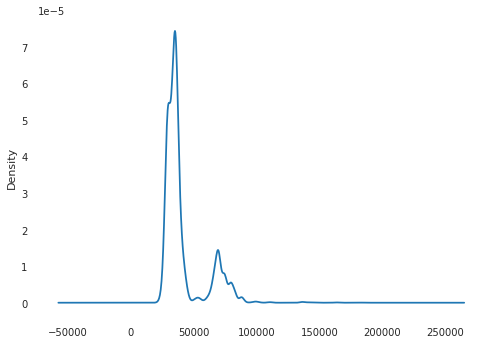

In [164]:
electric_cars['Base MSRP'].plot.density()

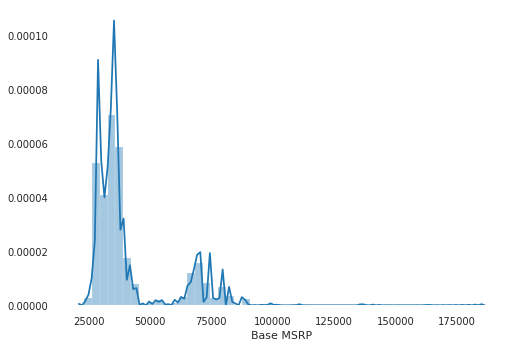

In [165]:
sns.distplot(electric_cars['Base MSRP'])

In [166]:
electric_cars['Make'].value_counts()

TESLA                   18159
NISSAN                  11021
CHEVROLET                7525
FORD                     3602
BMW                      2576
TOYOTA                   2522
KIA                      2115
AUDI                      773
CHRYSLER                  751
HYUNDAI                   716
FIAT                      701
HONDA                     591
VOLVO                     579
VOLKSWAGEN                473
MITSUBISHI                377
SMART                     242
PORSCHE                   233
MERCEDES-BENZ             214
MINI                      133
JAGUAR                    105
CADILLAC                   95
SUBARU                     39
FISKER                     18
AZURE DYNAMICS              9
LINCOLN                     6
WHEEGO ELECTRIC CARS        2
Name: Make, dtype: int64

In [167]:
electric_cars['Model'].value_counts()

LEAF                                   11021
MODEL 3                                10175
MODEL S                                 5506
VOLT                                    4675
BOLT                                    2617
                                       ...  
Q5 E                                       2
LIFE                                       2
PRIUS PLUG-IN HYBRID                       1
500                                        1
FUSION SPECIAL SERVICE VEHICLE PHEV        1
Name: Model, Length: 80, dtype: int64

In [168]:
electric_cars['Model Year'].value_counts()

2018    13473
2019     9457
2017     7718
2016     6305
2015     5108
2013     4955
2014     3789
2012     1773
2011      905
2020       40
2010       31
2008       23
Name: Model Year, dtype: int64

In [169]:
#Will use make, model, and model year might add other features
#Will do a randomsplit test
def wrangle1split(df):
  X = df.copy()
  y = X['Base MSRP']
  X = X[['Model Year','Make','Model','Electric Vehicle Type','Clean Alternative Fuel Vehicle (CAFV) Eligibility','Electric Range']]
  X_train,X_val,y_train,y_val = train_test_split(X,y,train_size = 0.8, test_size=0.2,random_state=42)
  return X_train, X_val, y_train, y_val

In [170]:
electric_cars.head(1)

,VIN (1-10),County,City,State,ZIP Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location
1,1FADP3R47E,King,Seattle,WA,98103,2014,FORD,FOCUS,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,76,29170.0,36.0,205611143,POINT (-122.343577 47.672491)


In [171]:
X_train ,X_val, y_train, y_val = wrangle1split(electric_cars)

In [172]:
y_train.head()

57511    33170.0
5549     36620.0
50107    31800.0
54851    28800.0
6548     36000.0
Name: Base MSRP, dtype: float64

In [173]:
#model Linear regressor try
model2 = make_pipeline(OneHotEncoder(),
                       SimpleImputer(),
                       LinearRegression())
model2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                     'Clean Alternative Fuel Vehicle (CAFV) '
                                     'Eligibility'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [174]:
ylintrain = model2.predict(X_train)
ylinval = model2.predict(X_val)
mean_absolute_error(y_train,ylintrain),mean_absolute_error(y_val,ylinval)

(1067.8149856533478, 1073.0042887536692)

In [175]:
X_train.head()

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range
57511,2016,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,53
5549,2019,CHEVROLET,BOLT,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,238
50107,2013,FIAT,500E,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,87
54851,2013,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,75
6548,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215


In [181]:
#First Model basic try other than baseline
model1 = make_pipeline(OneHotEncoder(),
                       SimpleImputer(),
                       RandomForestRegressor(random_state=42)
)
model1.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Make', 'Model', 'Electric Vehicle Type',
                                     'Clean Alternative Fuel Vehicle (CAFV) '
                                     'Eligibility'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                   

In [182]:
print("Training Score:",model1.score(X_train,y_train))

Training Score: 0.9999993024236821


In [183]:
y_train_pred = model1.predict(X_train)
y_val_pred = model1.predict(X_val)

In [184]:
print("Training r2score:",r2_score(y_train,y_train_pred))
print("Val r2score",r2_score(y_val,y_val_pred))

Training r2score: 0.9999993024236821
Val r2score 0.9999808478574652


In [185]:
print("Training mean absolute error",mean_absolute_error(y_train,y_train_pred))
print("Validation mean absolute error",mean_absolute_error(y_val,y_val_pred))

Training mean absolute error 0.20206714729007644
Validation mean absolute error 0.8492254572601716


In [186]:
X_val.head()

,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range
26408,2012,CHEVROLET,VOLT,Plug-in Hybrid Electric Vehicle (PHEV),Clean Alternative Fuel Vehicle Eligible,35
51890,2014,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,208
29817,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84
27096,2012,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,73
47373,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84


In [187]:
assert electric_cars.shape[0] == X_train.shape[0] + X_val.shape[0]

In [121]:
electric_cars['Base MSRP'].mean()

41042.97562386845